# <center>Freesound General-Purpose Audio Tagging Challenge</center>

![Logo](https://upload.wikimedia.org/wikipedia/commons/3/3c/Freesound_project_website_logo.png)

Freesound is a collaborative database of Creative Commons Licensed sounds. The aim of this competition is to classify audio files that cover real-world sounds from musical instruments, humans, animals, machines, etc. Few of the labels are: `Trumpet`, `Squeak`, `Meow`, `Applause` and `Finger_sapping`.  One of the challenges is that not all labels are manually verified. A creative solution should be able to partially rely on these *weak* annotations.

Let's take a tour of the data visualization and model building through this kernel. If you like this work, please show your support by upvotes. Happy Kaggling!

### Contents
1. [Exploratory Data Analysis](#eda)
    * [Loading data](#loading_data)
    * [Distribution of Categories](#distribution)
    * [Reading Audio Files](#audio_files)
    * [Audio Length](#audio_length)
2. [Building a Model using Raw Wave](#1d_model_building)
    * [Model Discription](#1d_discription)
    * [Configuration](#configuration)
    * [DataGenerator class](#data_generator)
    * [Normalization](#1d_normalization)
    * [Training 1D Conv](#1d_training)
    * [Ensembling 1D Conv Predictions](#1d_ensembling)
3. [Introduction to MFCC](#intro_mfcc)
    * [Generating MFCC using Librosa](#librosa_mfcc)
4. [Building a Model using MFCC](#2d_model_building)
    * [Preparing Data](#2d_data)
    * [Normalization](#2d_normalization)
    * [Training 2D Conv on MFCC](#2d_training)
    * [Ensembling 2D Conv Predictions](#2d_ensembling)
5. [Ensembling 1D Conv and 2D Conv Predictions](#1d_2d_ensembling)
6. [Results and Conclusion](#conclusion)


<a id="eda"></a>
## <center>1. Exploratory Data Analysis</center>

In [1]:
# Change this to True to replicate the result
COMPLETE_RUN = True

<a id="loading_data"></a>
### Loading data

In [2]:
import numpy as np
np.random.seed(1001)

import os
import shutil

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#from tqdm import tqdm_notebook
from sklearn.cross_validation import StratifiedKFold
import tensorflow as tf
print('tf:',tf.__version__)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)

#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

%matplotlib inline
matplotlib.style.use('ggplot')
os.getpid()

/home/lab507/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


tf: 1.8.0


9401

In [3]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/sample_submission.csv")

In [4]:
train.head()

fname         label  manually_verified
0  00044347.wav        Hi-hat                  0
1  001ca53d.wav     Saxophone                  1
2  002d256b.wav       Trumpet                  0
3  0033e230.wav  Glockenspiel                  1
4  00353774.wav         Cello                  1

In [5]:
print("Number of training examples=", train.shape[0], "  Number of classes=", len(train.label.unique()))

Number of training examples= 9473   Number of classes= 41


In [6]:
print(train.label.unique())

['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


<a id="distribution"></a>
### Distribution of Categories

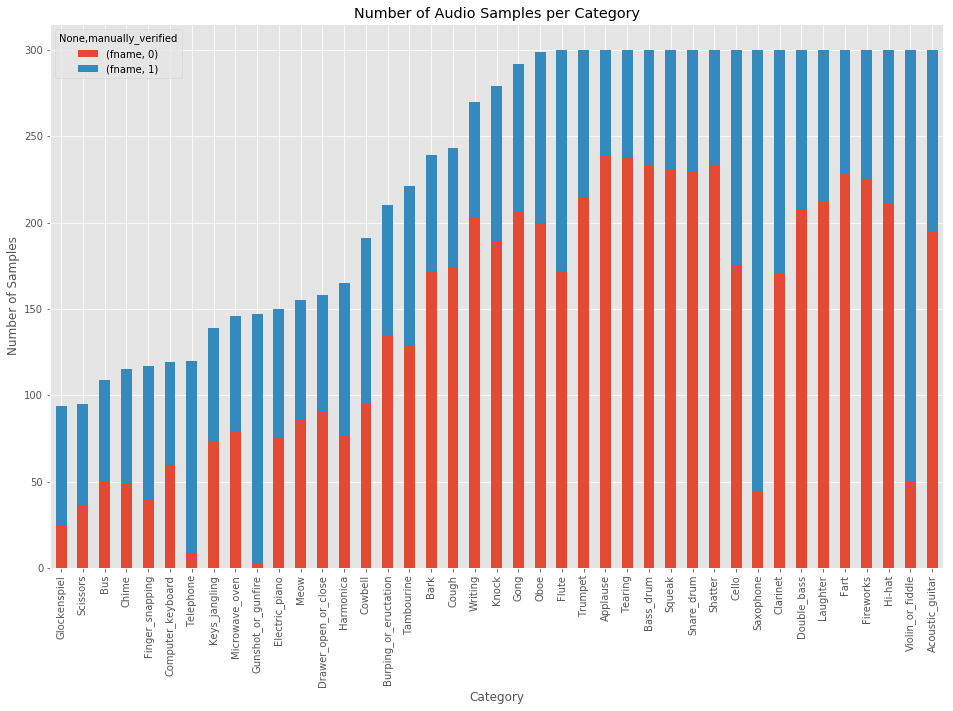

In [7]:
category_group = train.groupby(['label', 'manually_verified']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

In [8]:
print('Minimum samples per category = ', min(train.label.value_counts()))
print('Maximum samples per category = ', max(train.label.value_counts()))

Minimum samples per category =  94
Maximum samples per category =  300


We observe that:
1. The number of audio samples per category is **non-nform**. The minimum number of audio samples in a category is `94` while the maximum is `300`
2. Also, the proportion of `maually_verified` labels per category is non-uniform.
<a id="audio_files"></a>
### Reading Audio Files

The audios are [Pulse-code modulated](https://en.wikipedia.org/wiki/Audio_bit_depth) with a [bit depth](https://en.wikipedia.org/wiki/Audio_bit_depth) of 16 and a [sampling rate](https://en.wikipedia.org/wiki/Sampling_%28signal_processing%29) of 44.1 kHz

![16-bit PCM](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Pcm.svg/500px-Pcm.svg.png)

* **Bit-depth = 16**: The amplitude of each sample in the audio is one of 2^16 (=65536) possible values. 
* **Samplig rate = 44.1 kHz**: Each second in the audio consists of 44100 samples. So, if the duration of the audio file is 3.2 seconds, the audio will consist of 44100\*3.2 = 141120 values.

Let's listen to an audio file in our dataset and load it to a numpy array

In [9]:
import IPython.display as ipd  # To play sound in the notebook
fname = '../input/audio_train/' + '00044347.wav'
fname = '../input/audio_test/' + 'ffd9d282.wav'# Hi-hat
ipd.Audio(fname)

In [10]:
# Using wave library
import wave
wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  551250
Duration =  12.5


In [11]:
# Using scipy
from scipy.io import wavfile
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (551250,)
[ -7 -10  -8 ...  15  16  16]


Let's plot the audio frames

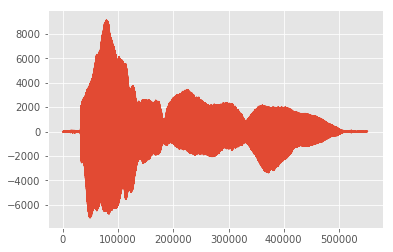

In [12]:
plt.plot(data, '-', );

Let's zoom in on first 1000 frames

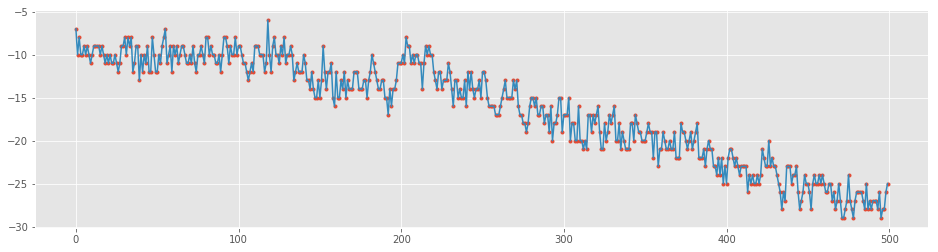

In [13]:
plt.figure(figsize=(16, 4))
plt.plot(data[:500], '.'); plt.plot(data[:500], '-');

<a id="audio_length"></a>
### Audio Length

We shall now analyze the lengths of the audio files in our dataset

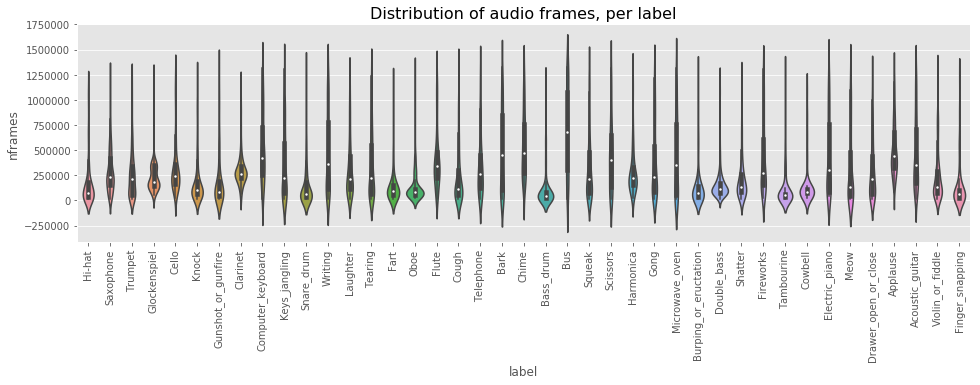

In [14]:
train['nframes'] = train['fname'].apply(lambda f: wave.open('../input/audio_train/' + f).getnframes())
test['nframes'] = test['fname'].apply(lambda f: wave.open('../input/audio_test/' + f).getnframes())

_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="label", y="nframes", data=train)
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

We observe:
1. The distribution of audio length across labels is non-uniform and has high variance.

Let's now analyze the frame length distribution in Train and Test.

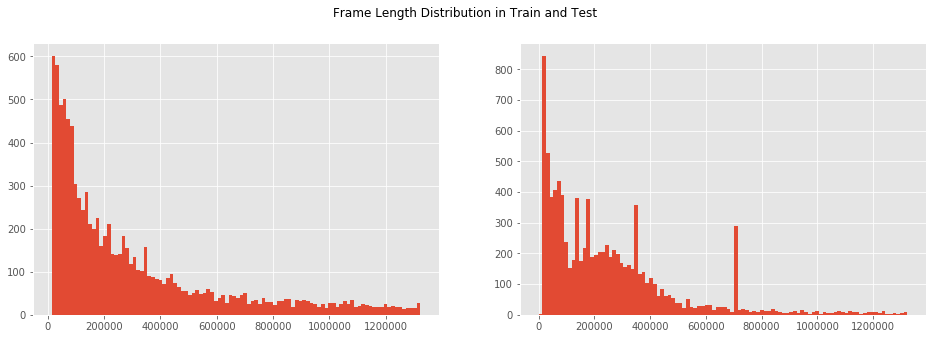

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
train.nframes.hist(bins=100, ax=axes[0])
test.nframes.hist(bins=100, ax=axes[1])
plt.suptitle('Frame Length Distribution in Train and Test', ha='center', fontsize='large');

We observe:
1. Majority of the audio files are short.
1. There are four `abnormal` length in the test histogram. Let's analyze them.

In [16]:
abnormal_length = [707364, 353682, 138474, 184338]

for length in abnormal_length:
    abnormal_fnames = test.loc[test.nframes == length, 'fname'].values
    print("Frame length = ", length, " Number of files = ", abnormal_fnames.shape[0], end="   ")
    fname = np.random.choice(abnormal_fnames)
    print("Playing ", fname)
    IPython.display.display(ipd.Audio( '../input/audio_test/' + fname))

Frame length =  707364  Number of files =  210   Playing  87f52da2.wav


Frame length =  353682  Number of files =  127   Playing  1819a7b7.wav


Frame length =  138474  Number of files =  170   Playing  32bdd578.wav


Frame length =  184338  Number of files =  153   Playing  113d2ca9.wav


<a id="1d_model_building"></a>
## <center>2. Building a Model using Raw Wave</center>
We will build two models:
1. The first model will take the raw audio (1D array) as input and the primary operation will be Conv1D
2. The second model will take the MFCCs as input. (We will explain MFCC later)

<a id="1d_discription"></a>
### Keras Model using raw wave

Our model has the architecture as follows:
![raw](https://raw.githubusercontent.com/zaffnet/images/master/images/raw_model.jpg)

**Important:**
Due to the time limit on Kaggle Kernels, it is not possible to perform 10-fold training of a large model. I have trained the model locally and uploaded its output files as a dataset. If you wish to train the bigger model, change `COMPLETE_RUN = True` at the beginning of the kernel.

#### Some sssential imports

In [17]:
import librosa
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical
import keras
print('keras:',keras.__version__)

keras: 2.2.0


Using TensorFlow backend.


<a id="configuration"></a>
#### Configuration

The Configuration object stores those learning parameters that are shared between data generators, models, and training functions. Anything that is `global` as far as the training is concerned can become the part of Configuration object.

In [18]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=41,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

<a id="data_generator"></a>
#### DataGenerator Class

The DataGenerator class inherits from **`keras.utils.Sequence`** . It is useful for preprocessing and feeding the data to a Keras model. 
* Once initialized with a batch_size, it computes the number of batches in an epoch. The **`__len__`** method tells Keras how many batches to draw in each epoch. 
* The **`__getitem__`** method takes an index (which is the batch number) and returns a batch of the data (both X and y) after calculating the offset. During test time, only `X` is returned.
* If we want to perform some action after each epoch (like shuffle the data, or increase the proportion of augmented data), we can use the **`on_epoch_end`** method.

Note:
**`Sequence`** are a safer way to do multiprocessing. This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.

In [19]:
class DataGenerator(Sequence):
    def __init__(self, config, data_dir, list_IDs, labels=None, 
                 batch_size=64, preprocessing_fn=lambda x: x, stretch = False):
        self.config = config
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end()
        self.dim = self.config.dim
        self.stretch = stretch

    def __len__(self):
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(list_IDs_temp)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))

        input_length = self.config.audio_length
        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir + ID
            
            # Read and Resample the audio
            data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate,
                                        res_type='kaiser_fast')
            #time stretch  
            if(self.stretch):
                tr = 1.2
                lgtr = np.log(tr)
                ts = 2 ** np.random.uniform(-lgtr, lgtr)
                data = librosa.effects.time_stretch(data, ts)
            
            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
                
            # Normalization + Other Preprocessing
            if self.config.use_mfcc:
                data = librosa.feature.mfcc(data, sr=self.config.sampling_rate,
                                                   n_mfcc=self.config.n_mfcc)
                data = np.expand_dims(data, axis=-1)
            else:
                data = self.preprocessing_fn(data)[:, np.newaxis]
            X[i,] = data

        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X

<a id="1d_normalization"></a>
#### Normalization

Normalization is a crucial preprocessing step. The simplest method is rescaling the range of features to scale the range in [0, 1]. 

In [20]:

def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5
"""
def audio_norm(data):
    max_data = np.max(np.absolute(data))
    return data/(max_data+1e-6)*0.5
"""

'\ndef audio_norm(data):\n    max_data = np.max(np.absolute(data))\n    return data/(max_data+1e-6)*0.5\n'

* The dummy model is just for debugging purpose.
* Our 1D Conv model is fairly deep and is trained using Adam Optimizer with a learning rate of 0.0001

In [21]:
def get_1d_dummy_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = GlobalMaxPool1D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

def get_1d_conv_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = Convolution1D(16, 9, activation=relu, padding="valid")(inp)
    x = Convolution1D(16, 9, activation=relu, padding="valid")(x)
    x = MaxPool1D(16)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(rate=0.2)(x)

    x = Dense(64, activation=relu)(x)
    x = Dense(128, activation=relu)(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

<a id="1d_training"></a>
#### Training 1D Conv

It is important to convert raw labels to integer indices

In [22]:
LABELS = list(train.label.unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
train.set_index("fname", inplace=True)
test.set_index("fname", inplace=True)
train["label_idx"] = train.label.apply(lambda x: label_idx[x])
if not COMPLETE_RUN:
    train = train[:2000]
    test = test[:2000]

In [23]:
config = Config(sampling_rate=16000, audio_duration=2, n_folds=10, learning_rate=0.001, max_epochs=100)
#config = Config(sampling_rate=16000, audio_duration=2, n_folds=10, learning_rate=0.001)
if not COMPLETE_RUN:
    config = Config(sampling_rate=100, audio_duration=1, n_folds=2, max_epochs=1)

Here is the code for 10-fold training:
* We use **`from sklearn.cross_validation.StratifiedKFold`** for splitting the trainig data into 10 folds.
* We use some Keras callbacks to monitor the training.
    * **`ModelCheckpoint`** saves the best weight of our model (using validation data). We use this weight to make test predictions.
    * **`EarlyStopping`** stops the training once validation loss ceases to decrease
    * **`TensorBoard`** helps us visualize training and validation loss and accuracy.
* We fit the model using **`DataGenerator`** for training and validation splits. 
* We get both training and test predictions and save them as .npy format. We also generate a submission file. For 10-fold CV, the number of prediction files should be 10. We will ensemble these predictions later.

In [24]:
#```python
stretch = True
PREDICTION_FOLDER = "predictions_1d_conv_stretch=1.2"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

skf = StratifiedKFold(train.label_idx, n_folds=config.n_folds)

for i, (train_split, val_split) in enumerate(skf):
    train_set = train.iloc[train_split]
    val_set = train.iloc[val_split]
    checkpoint = ModelCheckpoint('model/best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%d'%i, write_graph=True)

    callbacks_list = [checkpoint, early, tb]
    print("Fold: ", i)
    print("#"*50)
    if COMPLETE_RUN:
        model = get_1d_conv_model(config)
    else:
        model = get_1d_dummy_model(config)

    train_generator = DataGenerator(config, '../input/audio_train/', train_set.index, 
                                    train_set.label_idx, batch_size=64,
                                    preprocessing_fn=audio_norm, stretch = stretch)
    val_generator = DataGenerator(config, '../input/audio_train/', val_set.index, 
                                  val_set.label_idx, batch_size=64,
                                  preprocessing_fn=audio_norm, stretch = stretch)
    
    history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator,
                                  epochs=config.max_epochs, use_multiprocessing=True, workers=6, max_queue_size=20)
    
    model.load_weights('model/best_%d.h5'%i)
    
    # Save train predictions
    train_generator = DataGenerator(config, '../input/audio_train/', train.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(train_generator, use_multiprocessing=True, 
                                          workers=6, max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)
    
    # Save test predictions
    test_generator = DataGenerator(config, '../input/audio_test/', test.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(test_generator, use_multiprocessing=True, 
                                          workers=6, max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)
    
    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)
    #```

Fold:  0
##################################################
Epoch 1/100
134/134 [==============================] - 263s 2s/step - loss: 3.4418 - acc: 0.0687 - val_loss: 3.1350 - val_acc: 0.1236

Epoch 00001: val_loss improved from inf to 3.13504, saving model to model/best_0.h5
Epoch 2/100
134/134 [==============================] - 238s 2s/step - loss: 3.0189 - acc: 0.1399 - val_loss: 2.9741 - val_acc: 0.1770

Epoch 00002: val_loss improved from 3.13504 to 2.97407, saving model to model/best_0.h5
Epoch 3/100
134/134 [==============================] - 237s 2s/step - loss: 2.8574 - acc: 0.1863 - val_loss: 2.7549 - val_acc: 0.2073

Epoch 00003: val_loss improved from 2.97407 to 2.75488, saving model to model/best_0.h5
Epoch 4/100
134/134 [==============================] - 235s 2s/step - loss: 2.7506 - acc: 0.2121 - val_loss: 2.6148 - val_acc: 0.2419

Epoch 00004: val_loss improved from 2.75488 to 2.61482, saving model to model/best_0.h5
Epoch 5/100
134/134 [==============================]


Epoch 00004: val_loss improved from 2.75188 to 2.60620, saving model to model/best_1.h5
Epoch 5/100
134/134 [==============================] - 234s 2s/step - loss: 2.6079 - acc: 0.2571 - val_loss: 2.5255 - val_acc: 0.2634

Epoch 00005: val_loss improved from 2.60620 to 2.52548, saving model to model/best_1.h5
Epoch 6/100
134/134 [==============================] - 239s 2s/step - loss: 2.5226 - acc: 0.2733 - val_loss: 2.4809 - val_acc: 0.2949

Epoch 00006: val_loss improved from 2.52548 to 2.48086, saving model to model/best_1.h5
Epoch 7/100
134/134 [==============================] - 237s 2s/step - loss: 2.4215 - acc: 0.3034 - val_loss: 2.4313 - val_acc: 0.3012

Epoch 00007: val_loss improved from 2.48086 to 2.43126, saving model to model/best_1.h5
Epoch 8/100
134/134 [==============================] - 234s 2s/step - loss: 2.3721 - acc: 0.3096 - val_loss: 2.3659 - val_acc: 0.3075

Epoch 00008: val_loss improved from 2.43126 to 2.36587, saving model to model/best_1.h5
Epoch 9/100
134/134


Epoch 00007: val_loss improved from 2.52015 to 2.34208, saving model to model/best_2.h5
Epoch 8/100
134/134 [==============================] - 226s 2s/step - loss: 2.3922 - acc: 0.3115 - val_loss: 2.3865 - val_acc: 0.3225

Epoch 00008: val_loss did not improve from 2.34208
Epoch 9/100
134/134 [==============================] - 226s 2s/step - loss: 2.3250 - acc: 0.3245 - val_loss: 2.2176 - val_acc: 0.3666

Epoch 00009: val_loss improved from 2.34208 to 2.21763, saving model to model/best_2.h5
Epoch 10/100
134/134 [==============================] - 226s 2s/step - loss: 2.2852 - acc: 0.3347 - val_loss: 2.2351 - val_acc: 0.3624

Epoch 00010: val_loss did not improve from 2.21763
Epoch 11/100
134/134 [==============================] - 227s 2s/step - loss: 2.2341 - acc: 0.3504 - val_loss: 2.1727 - val_acc: 0.3718

Epoch 00011: val_loss improved from 2.21763 to 2.17266, saving model to model/best_2.h5
Epoch 12/100
134/134 [==============================] - 226s 2s/step - loss: 2.1964 - acc: 

134/134 [==============================] - 226s 2s/step - loss: 1.5691 - acc: 0.5368 - val_loss: 1.6396 - val_acc: 0.5252

Epoch 00048: val_loss did not improve from 1.62828
74/74 [==============================] - 104s 1s/step
Fold:  3
##################################################
Epoch 1/100
134/134 [==============================] - 256s 2s/step - loss: 3.4938 - acc: 0.0632 - val_loss: 3.2094 - val_acc: 0.1293

Epoch 00001: val_loss improved from inf to 3.20939, saving model to model/best_3.h5
Epoch 2/100
134/134 [==============================] - 227s 2s/step - loss: 3.0067 - acc: 0.1585 - val_loss: 2.8897 - val_acc: 0.1767

Epoch 00002: val_loss improved from 3.20939 to 2.88974, saving model to model/best_3.h5
Epoch 3/100
134/134 [==============================] - 229s 2s/step - loss: 2.8523 - acc: 0.1919 - val_loss: 2.7136 - val_acc: 0.2093

Epoch 00003: val_loss improved from 2.88974 to 2.71359, saving model to model/best_3.h5
Epoch 4/100
134/134 [==========================

134/134 [==============================] - 229s 2s/step - loss: 1.6626 - acc: 0.5066 - val_loss: 1.7382 - val_acc: 0.5079

Epoch 00037: val_loss did not improve from 1.68861
Epoch 38/100
134/134 [==============================] - 226s 2s/step - loss: 1.6537 - acc: 0.5141 - val_loss: 1.7138 - val_acc: 0.5089

Epoch 00038: val_loss did not improve from 1.68861
Epoch 39/100
134/134 [==============================] - 229s 2s/step - loss: 1.6376 - acc: 0.5129 - val_loss: 1.7184 - val_acc: 0.5068

Epoch 00039: val_loss did not improve from 1.68861
Epoch 40/100
134/134 [==============================] - 226s 2s/step - loss: 1.6281 - acc: 0.5138 - val_loss: 1.8276 - val_acc: 0.4669

Epoch 00040: val_loss did not improve from 1.68861
74/74 [==============================] - 104s 1s/step
Fold:  4
##################################################
Epoch 1/100
134/134 [==============================] - 251s 2s/step - loss: 3.5035 - acc: 0.0629 - val_loss: 3.1934 - val_acc: 0.1053

Epoch 00001: val

134/134 [==============================] - 232s 2s/step - loss: 1.7056 - acc: 0.5013 - val_loss: 1.7995 - val_acc: 0.4884

Epoch 00035: val_loss did not improve from 1.77531
Epoch 36/100
134/134 [==============================] - 228s 2s/step - loss: 1.6768 - acc: 0.4977 - val_loss: 1.8396 - val_acc: 0.4547

Epoch 00036: val_loss did not improve from 1.77531
Epoch 37/100
134/134 [==============================] - 230s 2s/step - loss: 1.6820 - acc: 0.5035 - val_loss: 1.7880 - val_acc: 0.4600

Epoch 00037: val_loss did not improve from 1.77531
Epoch 38/100
134/134 [==============================] - 232s 2s/step - loss: 1.6769 - acc: 0.5056 - val_loss: 1.7759 - val_acc: 0.4653

Epoch 00038: val_loss did not improve from 1.77531
74/74 [==============================] - 107s 1s/step
Fold:  5
##################################################
Epoch 1/100
134/134 [==============================] - 260s 2s/step - loss: 3.5069 - acc: 0.0595 - val_loss: 3.1701 - val_acc: 0.1258

Epoch 00001: val

134/134 [==============================] - 233s 2s/step - loss: 1.6446 - acc: 0.5092 - val_loss: 1.7839 - val_acc: 0.5000

Epoch 00035: val_loss did not improve from 1.78086
Epoch 36/100
134/134 [==============================] - 230s 2s/step - loss: 1.6401 - acc: 0.5205 - val_loss: 1.8390 - val_acc: 0.4736

Epoch 00036: val_loss did not improve from 1.78086
Epoch 37/100
134/134 [==============================] - 231s 2s/step - loss: 1.6402 - acc: 0.5177 - val_loss: 1.7202 - val_acc: 0.5349

Epoch 00037: val_loss improved from 1.78086 to 1.72016, saving model to model/best_5.h5
Epoch 38/100
134/134 [==============================] - 234s 2s/step - loss: 1.5959 - acc: 0.5234 - val_loss: 1.7507 - val_acc: 0.5085

Epoch 00038: val_loss did not improve from 1.72016
Epoch 39/100
134/134 [==============================] - 234s 2s/step - loss: 1.6114 - acc: 0.5238 - val_loss: 1.7862 - val_acc: 0.4968

Epoch 00039: val_loss did not improve from 1.72016
Epoch 40/100
134/134 [===================


Epoch 00005: val_loss improved from 2.65311 to 2.62999, saving model to model/best_7.h5
Epoch 6/100
134/134 [==============================] - 232s 2s/step - loss: 2.5856 - acc: 0.2556 - val_loss: 2.5564 - val_acc: 0.2736

Epoch 00006: val_loss improved from 2.62999 to 2.55636, saving model to model/best_7.h5
Epoch 7/100
134/134 [==============================] - 234s 2s/step - loss: 2.4849 - acc: 0.2785 - val_loss: 2.4124 - val_acc: 0.3054

Epoch 00007: val_loss improved from 2.55636 to 2.41236, saving model to model/best_7.h5
Epoch 8/100
134/134 [==============================] - 232s 2s/step - loss: 2.4045 - acc: 0.3062 - val_loss: 2.3582 - val_acc: 0.3256

Epoch 00008: val_loss improved from 2.41236 to 2.35815, saving model to model/best_7.h5
Epoch 9/100
134/134 [==============================] - 233s 2s/step - loss: 2.3432 - acc: 0.3254 - val_loss: 2.2975 - val_acc: 0.3351

Epoch 00009: val_loss improved from 2.35815 to 2.29754, saving model to model/best_7.h5
Epoch 10/100
134/13

134/134 [==============================] - 233s 2s/step - loss: 1.5691 - acc: 0.5392 - val_loss: 1.7111 - val_acc: 0.5101

Epoch 00045: val_loss did not improve from 1.68759
Epoch 46/100
134/134 [==============================] - 233s 2s/step - loss: 1.5867 - acc: 0.5342 - val_loss: 1.7272 - val_acc: 0.5080

Epoch 00046: val_loss did not improve from 1.68759
Epoch 47/100
134/134 [==============================] - 234s 2s/step - loss: 1.5562 - acc: 0.5429 - val_loss: 1.7125 - val_acc: 0.5037

Epoch 00047: val_loss did not improve from 1.68759
Epoch 48/100
134/134 [==============================] - 233s 2s/step - loss: 1.5514 - acc: 0.5387 - val_loss: 1.6728 - val_acc: 0.5175

Epoch 00048: val_loss improved from 1.68759 to 1.67280, saving model to model/best_7.h5
Epoch 49/100
134/134 [==============================] - 231s 2s/step - loss: 1.5503 - acc: 0.5464 - val_loss: 1.6959 - val_acc: 0.5196

Epoch 00049: val_loss did not improve from 1.67280
Epoch 50/100
134/134 [===================


Epoch 00004: val_loss improved from 2.77570 to 2.66552, saving model to model/best_9.h5
Epoch 5/100
134/134 [==============================] - 277s 2s/step - loss: 2.5773 - acc: 0.2518 - val_loss: 2.5496 - val_acc: 0.2607

Epoch 00005: val_loss improved from 2.66552 to 2.54960, saving model to model/best_9.h5
Epoch 6/100
134/134 [==============================] - 277s 2s/step - loss: 2.5022 - acc: 0.2731 - val_loss: 2.4899 - val_acc: 0.2927

Epoch 00006: val_loss improved from 2.54960 to 2.48993, saving model to model/best_9.h5
Epoch 7/100
134/134 [==============================] - 278s 2s/step - loss: 2.4185 - acc: 0.3023 - val_loss: 2.4471 - val_acc: 0.2917

Epoch 00007: val_loss improved from 2.48993 to 2.44710, saving model to model/best_9.h5
Epoch 8/100
134/134 [==============================] - 278s 2s/step - loss: 2.3598 - acc: 0.3197 - val_loss: 2.3405 - val_acc: 0.3248

Epoch 00008: val_loss improved from 2.44710 to 2.34050, saving model to model/best_9.h5
Epoch 9/100
134/134

<a id="1d_ensembling"></a>
#### Ensembling 1D Conv Predictions
Now that we have trained our model, it is time average the predictions of 10-folds. We will try Geometric Mean averaging and see what will be our Public LB score.

In [25]:
pred_list = []
for i in range(10):
    pred_list.append(np.load(PREDICTION_FOLDER+"/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('../input/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("1d_conv_ensembled_submission.csv", index=False)

<a id="intro_mfcc"></a>
## <center> 3. Introuction to MFCC

As we have seen in the previous section, our Deep Learning models are powerful enough to classify sounds from the raw audio. We do not require any complex feature engineering. But before the Deep Learning era, people developed techniques to extract features from audio signals. It turns out that these techniques are still useful. One such technique is computing the MFCC (Mel Frquency Cepstral Coefficients) from the raw audio. Before we jump to MFCC, let's talk about extracting features from the sound.

If we just want to classify some sound, we should build features that are **speaker independent**. Any feature that only gives information about the speaker (like the pitch of their voice) will not be helpful for classification. In other words, we should extract features that depend on the "content" of the audio rather than the nature of the speaker. Also, a good feature extraction technique should mimic the human speech perception. We don't hear loudness on a linear scale. If we want to double the perceived loudness of a sound, we have to put 8 times as much energy into it. Instead of a linear scale, our perception system uses a log scale. 

Taking these things into account, Davis and Mermelstein came up with MFCC in the 1980's. MFCC mimics the logarithmic perception of loudness and pitch of human auditory system and tries to eliminate speaker dependent characteristics by excluding the fundamental frequency and their harmonics. The underlying mathematics is quite complicated and we will skip that. For those interested, here is the [detailed explanation](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/).

![http://recognize-speech.com/images/FeatureExtraction/MFCC/MFCC_Flowchart.png](http://recognize-speech.com/images/FeatureExtraction/MFCC/MFCC_Flowchart.png)

<a id="librosa_mfcc"></a>
#### Generating MFCC using Librosa
The library librosa has a function to calculate MFCC. Let's compute the MFCC of an audio file and visualize it.

In [26]:
import librosa
SAMPLE_RATE = 44100
fname = '../input/freesound-audio-tagging/audio_train/' + '00044347.wav'   # Hi-hat
wav, _ = librosa.core.load(fname, sr=SAMPLE_RATE)
wav = wav[:2*44100]

FileNotFoundError: [Errno 2] No such file or directory: '/home/lab507/Desktop/ZMin/Final/input/freesound-audio-tagging/audio_train/00044347.wav'

In [ ]:
mfcc = librosa.feature.mfcc(wav, sr = SAMPLE_RATE, n_mfcc=40)
mfcc.shape

In [ ]:
plt.imshow(mfcc, cmap='hot', interpolation='nearest');

<a id="2d_model_building"></a>
## <center>4. Building a Model using MFCC

We will build now build a 2D Convolutional model using MFCC. 

In [ ]:
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras import backend as K

In [ ]:
def get_2d_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = GlobalMaxPool2D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model


def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

<a id="2d_data"></a>
### Preparing data

In [ ]:
config = Config(sampling_rate=44100, audio_duration=2, n_folds=10, 
                learning_rate=0.001, use_mfcc=True, n_mfcc=40)
if not COMPLETE_RUN:
    config = Config(sampling_rate=44100, audio_duration=2, n_folds=2, 
                    max_epochs=1, use_mfcc=True, n_mfcc=40)

In [ ]:
def prepare_data(df, config, data_dir):
    X = np.empty(shape=(df.shape[0], config.dim[0], config.dim[1], 1))
    input_length = config.audio_length
    for i, fname in enumerate(df.index):
        print(fname)
        file_path = data_dir + str(fname)
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

In [ ]:

X_train = prepare_data(train, config, '../input/freesound-audio-tagging/audio_train/')
X_test = prepare_data(test, config, '../input/freesound-audio-tagging/audio_test/')
y_train = to_categorical(train.label_idx, num_classes=config.n_classes)


<a id="2d_normalization"></a>
#### Normalization


In [ ]:

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std


<a id="2d_training"></a>
#### Training 2D Conv on MFCC

In [ ]:

PREDICTION_FOLDER = "predictions_2d_conv"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

skf = StratifiedKFold(train.label_idx, n_folds=config.n_folds)
for i, (train_split, val_split) in enumerate(skf):
    K.clear_session()
    X, y, X_val, y_val = X_train[train_split], y_train[train_split], X_train[val_split], y_train[val_split]
    checkpoint = ModelCheckpoint('model/best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%i'%i, write_graph=True)
    callbacks_list = [checkpoint, early, tb]
    print("#"*50)
    print("Fold: ", i)
    model = get_2d_conv_model(config)
    history = model.fit(X, y, validation_data=(X_val, y_val), callbacks=callbacks_list, 
                        batch_size=64, epochs=config.max_epochs)
    model.load_weights('model/best_%d.h5'%i)

    # Save train predictions
    predictions = model.predict(X_train, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)

    # Save test predictions
    predictions = model.predict(X_test, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)

    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)


<a id="2d_ensembling"></a>
#### Ensembling 2D Conv Predictions

In [ ]:
pred_list = []
for i in range(10):
    pred_list.append(np.load("../input/freesound-audio-tagging/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('../input/freesound-audio-tagging/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("2d_conv_ensembled_submission.csv", index=False)

<a id="1d_2d_ensembling"></a>
## <center>5. Ensembling 1D Conv and 2D Conv Predictions</center>

In [ ]:
import numpy as np

In [ ]:
#PREDICTION_FOLDER_1 = "predictions_1d_conv_norm"
PREDICTION_FOLDER_2 = "predictions_2d_conv_data_stretch=1.2"
PREDICTION_FOLDER_3 = "predictions_1d_conv"

In [ ]:
pred_list = []
#for i in range(10):
#    pred_list.append(np.load(PREDICTION_FOLDER_1 + "/test_predictions_%d.npy"%i))
for i in range(10):
    pred_list.append(np.load(PREDICTION_FOLDER_2 + "/test_predictions_%d.npy"%i))
for i in range(10):
    pred_list.append(np.load(PREDICTION_FOLDER_3 + "/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
predlog = np.zeros_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
    predlog = predlog + np.log(pred)
    
prediction = prediction**(1./len(pred_list))
predlog = predlog / (len(pred_list))

print(prediction[0])
print(predlog[0])

#using log
prediction = predlog

# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('../input/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("1d_2d_stretch=1.2_ensembled_submission_log.csv", index=False)

#### Adding Average

In [ ]:
pred_list_1 = []
pred_list_2 = []
pred_list_3 = []
#for i in range(10):
#    pred_list_1.append(np.load(PREDICTION_FOLDER_1 + "/test_predictions_%d.npy"%i))
for i in range(10):
    pred_list_2.append(np.load(PREDICTION_FOLDER_2 + "/test_predictions_%d.npy"%i))
for i in range(10):
    pred_list_3.append(np.load(PREDICTION_FOLDER_3 + "/test_predictions_%d.npy"%i))

#predlog_1 = np.zeros_like(pred_list_1[0])
predlog_2 = np.zeros_like(pred_list_2[0])
predlog_3 = np.zeros_like(pred_list_3[0])

#for pred in pred_list_1:
#    predlog_1 = predlog_1 + np.log(pred)
for pred in pred_list_2:
    predlog_2 = predlog_2 + np.log(pred)
for pred in pred_list_3:
    predlog_3 = predlog_3 + np.log(pred)
    
#predlog_1 = predlog_1 / (len(pred_list_1))
predlog_2 = predlog_2 / (len(pred_list_2))
predlog_3 = predlog_3 / (len(pred_list_3))


#using log
prediction = (np.exp(predlog_2) + np.exp(predlog_3)) / 2
#prediction = (predlog_1 + predlog_2 + predlog_3) / 3

print(prediction)

# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv('../input/sample_submission.csv')
test['label'] = predicted_labels
#test[['fname', 'label']].to_csv("1d_2d_stretch=1.2_ensembled_submission_log.csv", index=False)

<a id="conclusion"></a>
## <center>Results and Conclusion</center>

So far, we have trained two models. Let's analyze their relative complexity and strength.



| Model        | Number of Trainable parameters           | Public LB score  |
| ------------- |:-------------:| -----:|
| 1D Conv on Raw wave      | 360,513 | 0.809 |
| 2D Conv on MFCC (verified labels only)    | 168,361  |   0.785 |
| 2D Conv on MFCC     | 168,361  |   0.844 |
| 1D Conv + 2D Conv Ensemble     | N/A  |   0.895 |

**As we can see, 2D Convolution on MFCC performs better than 1D Convolution on Raw waves.**

## Coming Soon

1. Data Augmentation
2. Training on Manually Verified Labels